# Intern Data Challenge 2025 – Population Movement Simulation
### Prepared by: [Richel Ohenewaa Attafuah]

## Objective:
The purpose of this notebook is to estimate the future population distribution across ten geographic regions based on internal movement probabilities (`MoveProb`). This involves simulating one year of population changes under the following assumptions:
- Movement occurs only between adjacent regions (no external migration).
- Movement is influenced by each region's `MoveProb`, indicating the probability of residents moving out of a region.
- The redistribution of outgoing residents is based on a defined logic.

## Approach:
The notebook is organized into the following steps:
1. **Data Exploration:**  
   Perform exploratory data analysis (EDA) to understand the structure, detect anomalies, and summarize key statistics.
   
2. **Define Movement Logic:**  
   Set up region adjacency relationships and establish movement rules for distributing outgoing residents to adjacent regions.

3. **Simulation:**  
   Implement functions to:
   - Calculate outgoing residents.
   - Distribute residents to neighboring regions.
   - Compute the new population for each region after one year.

4. **Results and Visualization:**  
   Present the updated population distribution and analyze key insights.

5. **Conclusion:**  
   Summarize findings, including assumptions, limitations, and potential improvements to the model.


## Import Data

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
population_data = pd.read_csv("C:\\Users\\EWURA\\Desktop\\Internship Data Challenge\\population_data.csv")
population_data

,RegionID,Population,MoveProb
0,1,2205,0.0050
1,2,3581,0.0120
2,3,6019,0.0030
3,4,1847,0.0200
4,5,4422,0.0045
5,6,5230,0.0150
6,7,6394,0.0220
7,8,2560,0.0100
8,9,8510,0.0030
9,10,3851,0.0070


## Exploratory Data Analysis

In [34]:
# Check basic information about the dataset
population_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    10 non-null     int64  
 1   Population  10 non-null     int64  
 2   MoveProb    10 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 368.0 bytes


In [35]:
# Count missing values in each column
print(population_data.isnull().sum())

RegionID      0
Population    0
MoveProb      0
dtype: int64


In [36]:
population_data.describe()

,RegionID,Population,MoveProb
count,10.00000,10.000000,10.000000
mean,5.50000,4461.900000,0.010150
std,3.02765,2103.805042,0.006952
min,1.00000,1847.000000,0.003000
25%,3.25000,2815.250000,0.004625
50%,5.50000,4136.500000,0.008500
75%,7.75000,5821.750000,0.014250
max,10.00000,8510.000000,0.022000


### **Summary of Descriptive Statistics**

- The dataset includes **10 regions** with varying populations and movement probabilities.
- **Population** ranges from **1,847** to **8,510**, with a mean of **4,461.9**. Regions show moderate variation in population, with some regions being significantly larger than others.
- **MoveProb** values range from **0.003** to **0.022**, with a mean of **0.0102**. Movement probabilities are low across regions, indicating that only a small portion of residents is expected to move each year.
- The data shows no missing values or anomalies, ensuring readiness for simulation.



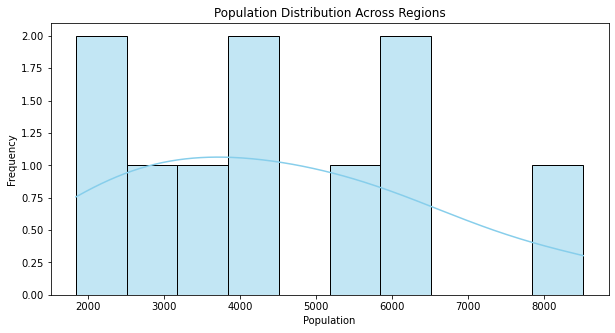

In [37]:
# Histogram for Population
plt.figure(figsize=(10, 5))
sns.histplot(population_data['Population'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title('Population Distribution Across Regions')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

### **Comment on the Population Distribution**

- The distribution of population across regions appears to be **slightly uneven** with multiple peaks, suggesting that certain regions have significantly higher populations than others.
- There are **no extreme outliers**, but the distribution is not fully normal or symmetric.
- Most regions have populations concentrated in moderate to high ranges, with only a few regions having lower populations.
- This variation is important for the simulation since regions with larger populations may have a greater impact on overall movement trends.

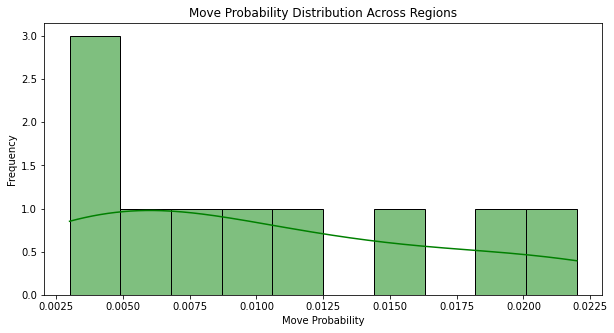

In [38]:
# Histogram for Move Probability
plt.figure(figsize=(10, 5))
sns.histplot(population_data['MoveProb'], bins=10, kde=True, color='green', edgecolor='black')
plt.title('Move Probability Distribution Across Regions')
plt.xlabel('Move Probability')
plt.ylabel('Frequency')
plt.show()

### **Comment on the Move Probability Distribution**

- The distribution of move probability (`MoveProb`) is **right-skewed**, with most regions having low probabilities of movement.
- A significant number of regions have `MoveProb` values near the lower end of the range (close to **0.003**), suggesting that movement is generally unlikely across most regions.
- There are no regions with `MoveProb` values higher than **0.022**, confirming that all probabilities fall within a reasonable range.
- This distribution indicates that large-scale population movement may not occur rapidly within one year, with smaller, localized changes likely dominating the simulation.

In [39]:
# Correlation between Population and MoveProb
correlation = population_data['Population'].corr(population_data['MoveProb'])
print(f"Correlation between Population and MoveProb: {correlation:.2f}")

Correlation between Population and MoveProb: -0.20


The correlation between Population and MoveProb is -0.20, indicating a weak negative relationship.
This suggests that regions with higher populations tend to have slightly lower movement probabilities, while regions with lower populations may have slightly higher movement tendencies.

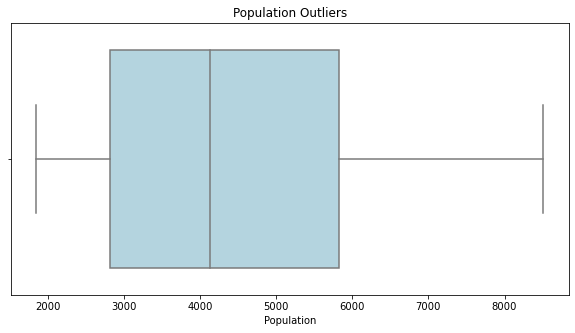

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=population_data['Population'], color='lightblue')
plt.title('Population Outliers')
plt.show()

The boxplot for Population shows no outliers, as all data points fall within the whiskers (which represent the range between the minimum and maximum values).

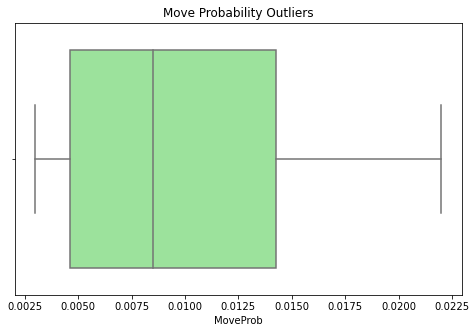

In [41]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=population_data['MoveProb'], color='lightgreen')
plt.title('Move Probability Outliers')
plt.show()

The boxplot for move probability shows no outliers, as all data points fall within the whiskers (which represent the range between the minimum and maximum values).

In [42]:
# Total population at the start
initial_population = population_data['Population'].sum()
print(f"Initial Total Population: {initial_population}")

Initial Total Population: 44619


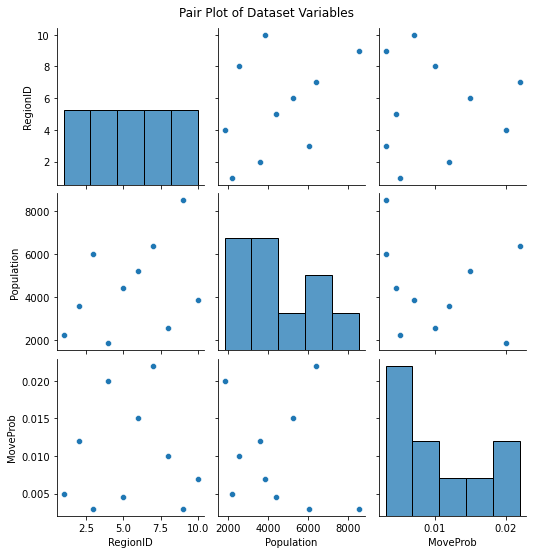

In [43]:
# Pair plot to see relationships between Population and MoveProb
sns.pairplot(population_data)
plt.suptitle('Pair Plot of Dataset Variables', y=1.02)
plt.show()

The pair plot shows relationships between RegionID, Population, and MoveProb.
There is no strong linear relationship between Population and MoveProb, which aligns with the weak correlation of -0.20 observed earlier.
Population exhibits moderate variability across regions, while MoveProb is concentrated in lower values, consistent with previous visualizations.
The scatter points indicate minimal clustering or trend patterns, suggesting that population and movement probability are relatively independent.

## Movement Logic

In [44]:
# Define adjacency structure
adjacency = {
    1: [2, 4],
    2: [1, 3, 5],
    3: [2, 6],
    4: [1, 5, 7],
    5: [2, 4, 6, 8],
    6: [3, 5, 9],
    7: [4, 8],
    8: [5, 7, 9, 10],
    9: [6, 8, 10],
    10: [8, 9]
}

## Movement Logic and Assumptions:
1. Residents move to **adjacent regions** based on the defined adjacency structure.
2. The number of residents moving out of a region is calculated as `Outgoing = Population * MoveProb`.
3. Outgoing residents are distributed **equally** among all adjacent regions.
4. No new residents enter or leave the entire system, ensuring population conservation.

In [45]:
# Display adjacency structure
for region, neighbors in adjacency.items():
    print(f"Region {region} is adjacent to: {neighbors}")

Region 1 is adjacent to: [2, 4]
Region 2 is adjacent to: [1, 3, 5]
Region 3 is adjacent to: [2, 6]
Region 4 is adjacent to: [1, 5, 7]
Region 5 is adjacent to: [2, 4, 6, 8]
Region 6 is adjacent to: [3, 5, 9]
Region 7 is adjacent to: [4, 8]
Region 8 is adjacent to: [5, 7, 9, 10]
Region 9 is adjacent to: [6, 8, 10]
Region 10 is adjacent to: [8, 9]


## Calculate Outgoing Residents
We calculate the outgoing residents using the formula:
**Outgoing = Population * MoveProb**

In [48]:
# Calculate outgoing residents for each region
population_data['Outgoing'] = population_data['Population'] * population_data['MoveProb']

# Display the updated data
print(population_data[['RegionID', 'Population', 'MoveProb', 'Outgoing']])

   RegionID  Population  MoveProb  Outgoing
0         1        2205    0.0050    11.025
1         2        3581    0.0120    42.972
2         3        6019    0.0030    18.057
3         4        1847    0.0200    36.940
4         5        4422    0.0045    19.899
5         6        5230    0.0150    78.450
6         7        6394    0.0220   140.668
7         8        2560    0.0100    25.600
8         9        8510    0.0030    25.530
9        10        3851    0.0070    26.957


Outgoing residents need to be distributed among adjacent regions.
We assume equal distribution for simplicity, where outgoing residents are divided evenly across all adjacent regions.

In [52]:
def distribute_population(population_data, adjacency):
    # Initialize incoming residents count for each region
    incoming = {region: 0 for region in population_data['RegionID']}

    # Loop through each region to calculate outgoing and distribute to neighbors
    for _, row in population_data.iterrows():
        region_id = row['RegionID']
        outgoing = row['Outgoing']
        adj_regions = adjacency[region_id]  # Get adjacent regions

        # Distribute evenly to adjacent regions
        if adj_regions:
            share = outgoing / len(adj_regions)  # Divide equally
            for adj_region in adj_regions:
                incoming[adj_region] += share

    return incoming

In [53]:
# Distribute outgoing residents and get incoming population for each region
incoming_movement = distribute_population(population_data, adjacency)

# Add the incoming population data to the DataFrame
population_data['Incoming'] = population_data['RegionID'].map(incoming_movement)

# Display updated data
print(population_data[['RegionID', 'Population', 'Outgoing', 'Incoming']])

   RegionID  Population  Outgoing   Incoming
0         1        2205    11.025  26.637333
1         2        3581    42.972  19.515750
2         3        6019    18.057  40.474000
3         4        1847    36.940  80.821250
4         5        4422    19.899  59.187333
5         6        5230    78.450  22.513250
6         7        6394   140.668  18.713333
7         8        2560    25.600  97.297250
8         9        8510    25.530  46.028500
9        10        3851    26.957  14.910000


In [54]:
# Calculate the new population after movement
population_data['NewPopulation'] = population_data['Population'] - population_data['Outgoing'] + population_data['Incoming']

# Display the final data
print(population_data[['RegionID', 'Population', 'Outgoing', 'Incoming', 'NewPopulation']])


   RegionID  Population  Outgoing   Incoming  NewPopulation
0         1        2205    11.025  26.637333    2220.612333
1         2        3581    42.972  19.515750    3557.543750
2         3        6019    18.057  40.474000    6041.417000
3         4        1847    36.940  80.821250    1890.881250
4         5        4422    19.899  59.187333    4461.288333
5         6        5230    78.450  22.513250    5174.063250
6         7        6394   140.668  18.713333    6272.045333
7         8        2560    25.600  97.297250    2631.697250
8         9        8510    25.530  46.028500    8530.498500
9        10        3851    26.957  14.910000    3838.953000


In [55]:
# Check if total population is conserved
initial_population = population_data['Population'].sum()
final_population = population_data['NewPopulation'].sum()

print(f"Initial Population: {initial_population}")
print(f"Final Population: {final_population}")
assert initial_population == final_population, "Population is not conserved!"

Initial Population: 44619
Final Population: 44619.0


## Outgoing and Incoming Population Calculation:
1. Outgoing residents were calculated using the formula `Outgoing = Population * MoveProb`.
2. Outgoing residents were distributed equally among adjacent regions.
3. The new population for each region was updated as `NewPopulation = Population - Outgoing + Incoming`.
4. Total population was verified to remain constant before and after the simulation.

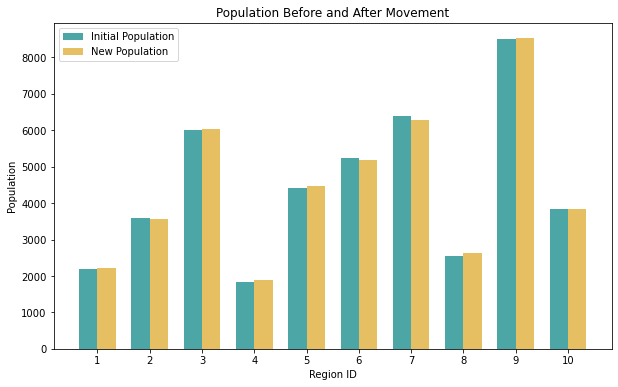

In [63]:
# Define bar positions
x = np.arange(len(population_data['RegionID']))  # Position for each RegionID
width = 0.35  # Width of each bar

# Plot side-by-side bars
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, population_data['Population'], width, label='Initial Population', color='teal', alpha=0.7)
plt.bar(x + width/2, population_data['NewPopulation'], width, label='New Population', color='goldenrod', alpha=0.7)

# Add labels and titles
plt.xlabel('Region ID')
plt.ylabel('Population')
plt.title('Population Before and After Movement')
plt.xticks(x, population_data['RegionID'])
plt.legend()

# Display the plot
plt.show()


### Population Before and After Movement by Region
This plot provides a comparison between the initial and new population values for each region.
Key observations:
1. Some regions (e.g., Region 4 and Region 8) experienced population increases after the movement, driven by high incoming residents.
2. Regions with high outgoing residents (e.g., Region 7 and Region 6) show a decrease in population.
3. Overall, the changes reflect the effect of both outgoing and incoming movement based on the adjacency structure.
4. Total population remains consistent across regions, verifying population conservation in the simulation.

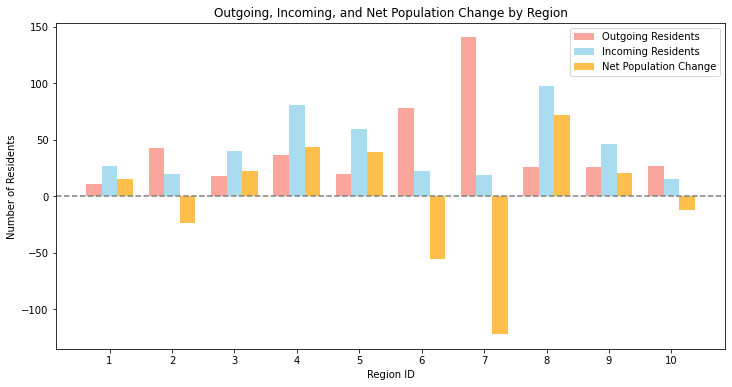

In [64]:
# Calculate net population change if not already done
population_data['PopulationChange'] = population_data['NewPopulation'] - population_data['Population']

# Define bar positions
x = np.arange(len(population_data['RegionID']))  # Positions for each Region ID
width = 0.25  # Width of each bar

# Plot side-by-side bars
plt.figure(figsize=(12, 6))
plt.bar(x - width, population_data['Outgoing'], width, label='Outgoing Residents', color='salmon', alpha=0.7)
plt.bar(x, population_data['Incoming'], width, label='Incoming Residents', color='skyblue', alpha=0.7)
plt.bar(x + width, population_data['PopulationChange'], width, label='Net Population Change', color='orange', alpha=0.7)

# Add labels and titles
plt.xlabel('Region ID')
plt.ylabel('Number of Residents')
plt.title('Outgoing, Incoming, and Net Population Change by Region')
plt.xticks(x, population_data['RegionID'])
plt.axhline(y=0, color='gray', linestyle='--')  # Add reference line at zero
plt.legend()

# Display the plot
plt.show()

### Population Movement Analysis

This plot provides a side-by-side comparison of outgoing residents, incoming residents, 
and net population change for each region.

Key Observations:
1. Regions with high outgoing residents (e.g., Region 7) experienced large population losses, 
   as indicated by the negative net change (orange bars).
2. Regions such as Region 4 and Region 8 received a high number of incoming residents, 
   resulting in positive net population change.
3. The reference line at zero helps distinguish between regions that gained or lost population 
   during the simulation.
4. The balance between outgoing and incoming residents shows how the adjacency structure 
   and movement probability influenced regional population changes.